# TSFRESH Robot Failure Example
This example show shows how to use [tsfresh](https://tsfresh.readthedocs.io/) to exctract useful features from multiple timeseries and use them to improve classification performance.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import FeatureExtractionSettings
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

## Load and visualize data
The data consists of timeseries for 88 robots (`id` 1 - 88).  For each robot, each timepoint (`time`) contains datapoints from 6 sensors (`a` - `f`) leading up to a success or failure (`y`).

In [2]:
download_robot_execution_failures()
df, y = load_robot_execution_failures()
df.head()

,id,time,a,b,c,d,e,f
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


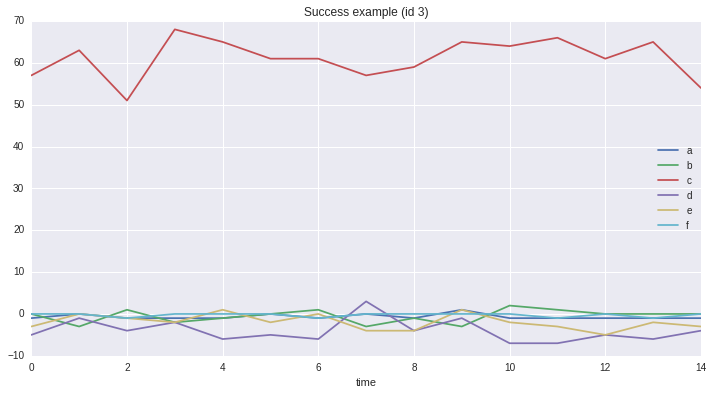

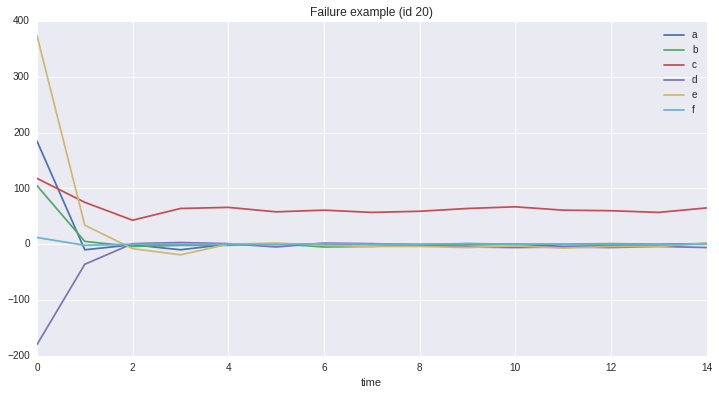

In [3]:
df[df.id == 3][['time', 'a', 'b', 'c', 'd', 'e', 'f']].plot(x='time', title='Success example (id 3)', figsize=(12, 6));
df[df.id == 20][['time', 'a', 'b', 'c', 'd', 'e', 'f']].plot(x='time', title='Failure example (id 20)', figsize=(12, 6));

## Extract Features

In [4]:
extraction_settings = FeatureExtractionSettings()
extraction_settings.IMPUTE = impute    # Fill in Infs and NaNs

In [5]:
%time X = extract_features(df, column_id='id', column_sort='time', feature_extraction_settings=extraction_settings);

CPU times: user 50.9 s, sys: 8 ms, total: 50.9 s
Wall time: 51 s


In [6]:
X.head()

,a__symmetry_looking__r_0.05,a__symmetry_looking__r_0.85,a__mean_abs_change_quantiles__qh_1.0__ql_0.8,a__symmetry_looking__r_0.8,a__symmetry_looking__r_0.9,a__mean_abs_change_quantiles__qh_1.0__ql_0.2,a__symmetry_looking__r_0.5,a__mean_abs_change_quantiles__qh_1.0__ql_0.0,a__large_standard_deviation__r_0.45,a__absolute_sum_of_changes,...,f__fft_coefficient__coeff_0,f__fft_coefficient__coeff_1,f__fft_coefficient__coeff_2,f__fft_coefficient__coeff_3,f__fft_coefficient__coeff_4,f__fft_coefficient__coeff_5,f__fft_coefficient__coeff_6,f__fft_coefficient__coeff_7,f__fft_coefficient__coeff_8,f__fft_coefficient__coeff_9
1,0.0,1.0,0.142857,1.0,1.0,0.142857,1.0,0.142857,0.0,2.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
2,1.0,1.0,0.000000,1.0,1.0,0.400000,1.0,1.000000,0.0,14.0,...,-4.0,0.744415,1.273659,-0.809017,1.373619,0.5,0.309017,-1.391693,0.0,0.0
3,0.0,1.0,0.000000,1.0,1.0,0.714286,1.0,0.714286,0.0,10.0,...,-4.0,-0.424716,0.878188,1.000000,1.851767,0.5,1.000000,-2.805239,0.0,0.0
4,0.0,1.0,0.000000,1.0,1.0,0.800000,1.0,1.214286,0.0,17.0,...,-5.0,-1.078108,3.678858,-3.618034,-1.466977,-0.5,-1.381966,-0.633773,0.0,0.0
5,0.0,1.0,2.000000,1.0,1.0,0.916667,1.0,0.928571,0.0,13.0,...,-2.0,-3.743460,3.049653,-0.618034,1.198375,-0.5,1.618034,-0.004568,0.0,0.0


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 1236 entries, a__symmetry_looking__r_0.05 to f__fft_coefficient__coeff_9
dtypes: float64(1236)
memory usage: 850.4 KB


In [8]:
%time X_filtered = extract_relevant_features(df, y, column_id='id', column_sort='time', feature_extraction_settings=extraction_settings)

CPU times: user 57.9 s, sys: 24 ms, total: 57.9 s
Wall time: 58 s


In [9]:
X_filtered.head()

,a__abs_energy,a__range_count__max_1__min_-1,b__abs_energy,e__standard_deviation,e__variance,e__abs_energy,c__standard_deviation,c__variance,a__variance,a__standard_deviation,...,f__spkt_welch_density__coeff_5,a__count_above_mean,d__mean_abs_change_quantiles__qh_0.8__ql_0.6,e__minimum,f__maximum,e__kurtosis,a__mean_abs_change_quantiles__qh_0.4__ql_0.2,c__count_below_mean,b__autocorrelation__lag_3,b__has_duplicate_max
1,14.0,15.0,13.0,0.471405,0.222222,10.0,1.203698,1.448889,0.062222,0.249444,...,0.000000,1.0,0.0,-1.0,0.0,-1.615385,0.0,5.0,-0.090909,1.0
2,25.0,13.0,76.0,2.054805,4.222222,90.0,4.333846,18.782222,0.915556,0.956847,...,0.023212,6.0,0.0,-5.0,0.0,1.971575,0.0,7.0,-0.354515,1.0
3,12.0,14.0,40.0,1.768867,3.128889,103.0,4.616877,21.315556,0.355556,0.596285,...,0.231630,4.0,2.0,-5.0,0.0,-0.781200,0.0,8.0,-0.326860,0.0
4,16.0,10.0,60.0,2.669998,7.128889,124.0,3.833188,14.693333,0.906667,0.952190,...,0.375456,8.0,1.0,-6.0,1.0,-0.416451,0.0,7.0,-0.053646,0.0
5,17.0,13.0,46.0,2.039608,4.160000,180.0,4.841487,23.440000,0.773333,0.879394,...,0.371239,5.0,0.0,-5.0,1.0,3.048096,0.0,10.0,-0.148575,0.0


In [10]:
X_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 1 to 88
Columns: 283 entries, a__abs_energy to b__has_duplicate_max
dtypes: float64(283)
memory usage: 195.2 KB


## Train and evaluate classifier

In [11]:
X_train, X_test, X_filtered_train, X_filtered_test, y_train, y_test = train_test_split(X, X_filtered, y, test_size=.4)

In [12]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        10
          1       1.00      0.96      0.98        26

avg / total       0.97      0.97      0.97        36



In [13]:
cl.n_features_

1236

In [14]:
cl2 = DecisionTreeClassifier()
cl2.fit(X_filtered_train, y_train)
print(classification_report(y_test, cl2.predict(X_filtered_test)))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95        10
          1       1.00      0.96      0.98        26

avg / total       0.97      0.97      0.97        36



In [15]:
cl2.n_features_

283

Compared to using all (1236) features, using only the (283) relevant features achieves better classification performance with less data.